<h1><center> PPOL564 | DS1: Foundations </center><h1>
<h3><center> Lecture 25 <br><br><font color='grey'> 
Simulation </font></center></h3>

### Today's Topics

- Simulating data generating processes
- Agent Based Models

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.discrete.discrete_model as smd
import warnings
import requests
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Simulation 

### Simulating a data generating process for a linear model

In [2]:
np.random.seed(5)
N = 1000
x1 = np.random.normal(size=N)
x2 = np.random.normal(size=N)
error = np.random.normal(size=N)
y = 1 + .5*x1 + -2*x2 + 3*x1*x2 + error
D = pd.DataFrame(dict(y=y,x1 = x1, x2 = x2))
D.head()

,y,x1,x2
0,1.226925,0.441227,0.542769
1,1.935195,-0.330870,0.400912
2,3.962403,2.430771,0.719705
3,1.224431,-0.252092,-0.021605
4,1.130109,0.109610,0.024040


In [3]:
sm.ols('y ~ x1 + x2 + x1*x2', data=D).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     4305.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        07:52:27   Log-Likelihood:                -1425.5
No. Observations:                1000   AIC:                             2859.
Df Residuals:                     996   BIC:                             2879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9721      0.032     30.445      0.000       0.909       1.035
x1             0.5047      0.032     15.657      0.000       0.441       0.568
x2            -2.0575      0.032    -64.081      0.000      -2.120      -1.994
x1:x2          3.0042      0.031     97.633      0.000       2.944       3.065
==============================================================================
Omnibus:                        4.346   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                3.615
Skew:                          -0.051   Prob(JB):                        0.164
Kurtosis:                       2.724   Cond. No.                         1.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Monte Carlo Simulation

Let's simulate the data many times, retaining the the coefficients on each iteration

In [4]:
coefs = []
sims = 1000
N = 100
b = [1,.5,-2,3]
for i in range(sims):
    x1 = np.random.normal(size=N)
    x2 = np.random.normal(size=N)
    error = np.random.normal(size=N)
    y = b[0] + b[1]*x1 + b[2]*x2 + b[3]*x1*x2 + error
    D = pd.DataFrame(dict(y=y,x1 = x1, x2 = x2))
    mod = sm.ols('y ~ x1 + x2 + x1*x2', data=D).fit()
    coefs.append(mod.params.tolist())

# Convert to a array
coefs = np.array(coefs)

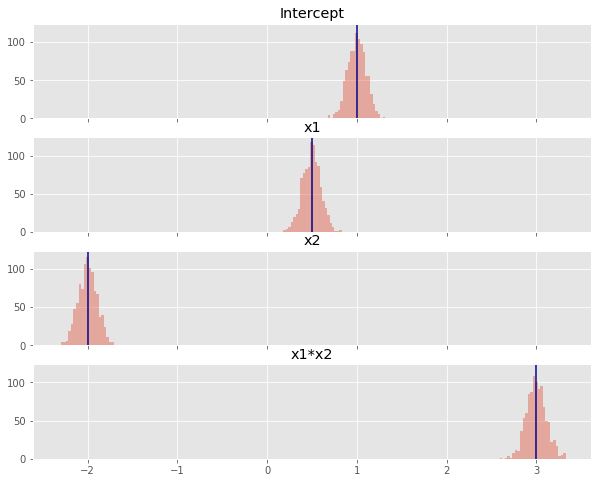

In [5]:
fig, axs = plt.subplots(4,1, sharex=True, sharey=True,figsize=(10,8))
sns.distplot(coefs[:,0],kde=False,ax=axs[0])
sns.distplot(coefs[:,1],kde=False,ax=axs[1])
sns.distplot(coefs[:,2],kde=False,ax=axs[2])
sns.distplot(coefs[:,3],kde=False,ax=axs[3])

# Plot the position of the "true" coefficient values. 
axs[0].axvline(b[0],color="darkblue")
axs[1].axvline(b[1],color="darkblue")
axs[2].axvline(b[2],color="darkblue")
axs[3].axvline(b[3],color="darkblue")

# Plot the titles for each subplot
axs[0].title.set_text('Intercept')
axs[1].title.set_text('x1')
axs[2].title.set_text('x2')
axs[3].title.set_text('x1*x2')
fig.show()

### Monte Carlo Simulation of a Statistical Error: _omitted variable bias_

Let's now simulate the impact of Omitted variable bias. Let's say there is some unobserved variable $z$ that is correlated with $x_1$ and $x_2$. How would that bias our estimates?

In the below code everything is the same except that we're adding variable $z$ that is correlated with the outcomes and the two predictors. 

In [6]:
coefs = []
sims = 1000
N = 100
b = [1,.5,-2,3]
for i in range(sims):
    z = np.random.normal(1,3,size=N) 
    x1 = np.random.normal(size=N) + z
    x2 = np.random.normal(size=N) - z
    error = np.random.normal(size=N)
    y = b[0] + b[1]*x1 + b[2]*x2 + b[3]*x1*x2 + 5*z  + error
    D = pd.DataFrame(dict(y=y,x1 = x1, x2 = x2))
    mod = sm.ols('y ~ x1 + x2 + x1*x2', data=D).fit()
    coefs.append(mod.params.tolist())

# Convert to a array
coefs = np.array(coefs)

As the plots below show, $z$ is a confounding variable. By not including it in the model, we are biasing our estimates of $\beta_1$ and $\beta_2$

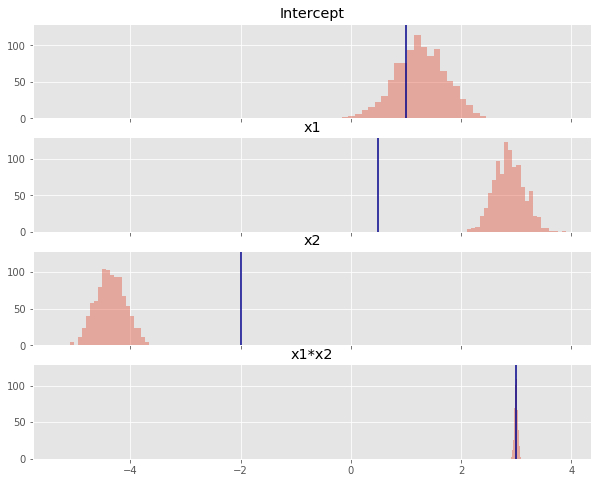

In [7]:
fig, axs = plt.subplots(4,1, sharex=True, sharey=True,figsize=(10,8))
sns.distplot(coefs[:,0],kde=False,ax=axs[0])
sns.distplot(coefs[:,1],kde=False,ax=axs[1])
sns.distplot(coefs[:,2],kde=False,ax=axs[2])
sns.distplot(coefs[:,3],kde=False,ax=axs[3])

# Plot the position of the "true" coefficient values. 
axs[0].axvline(b[0],color="darkblue")
axs[1].axvline(b[1],color="darkblue")
axs[2].axvline(b[2],color="darkblue")
axs[3].axvline(b[3],color="darkblue")

# Plot the titles for each subplot
axs[0].title.set_text('Intercept')
axs[1].title.set_text('x1')
axs[2].title.set_text('x2')
axs[3].title.set_text('x1*x2')
fig.show()

## Simulating Different Types of Outcomes

### Binary Outcome

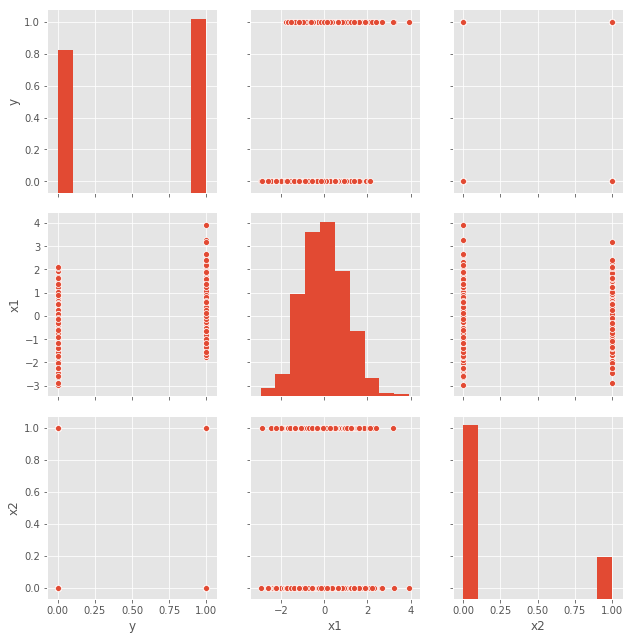

In [8]:
np.random.seed(12345)
N = 1000 # Number of observations

# Linear combination of predictors
x1 = np.random.normal(size=N)            # One continuous predictor 
x2 = np.random.binomial(1,p=.2,size=N)   # One binary predictor 
X = np.column_stack([np.ones(N),x1,x2])  # Compose as a matrix

B = np.array([.5,.7,-2])                 # True Coefficients
mu  = X.dot(B)                           # average prob is a function of x1 and x2

# Convert our linear combination into a probability space
pr = st.norm.cdf(mu,0,1) 

# Convert into binary outcome using the Bernoulli distribution
y = np.random.binomial(n=1,p = pr)

# Visualize
sns.pairplot(pd.DataFrame(dict(y=y,x1=x1,x2=x2)),height=3)
plt.show()

In [9]:
smd.Probit(y,X).fit().summary()

Optimization terminated successfully.
         Current function value: 0.489036
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                         Probit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Wed, 04 Dec 2019   Pseudo R-squ.:                  0.2895
Time:                        07:52:58   Log-Likelihood:                -489.04
converged:                       True   LL-Null:                       -688.34
                                        LLR p-value:                 2.782e-87
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5017      0.051      9.862      0.000       0.402       0.601
x1             0.7307      0.058     12.701      0.000       0.618       0.843
x2            -2.0212      0.150    -13.473      0.000      -2.315      -1.727
==============================================================================
"""

### Count Outcome

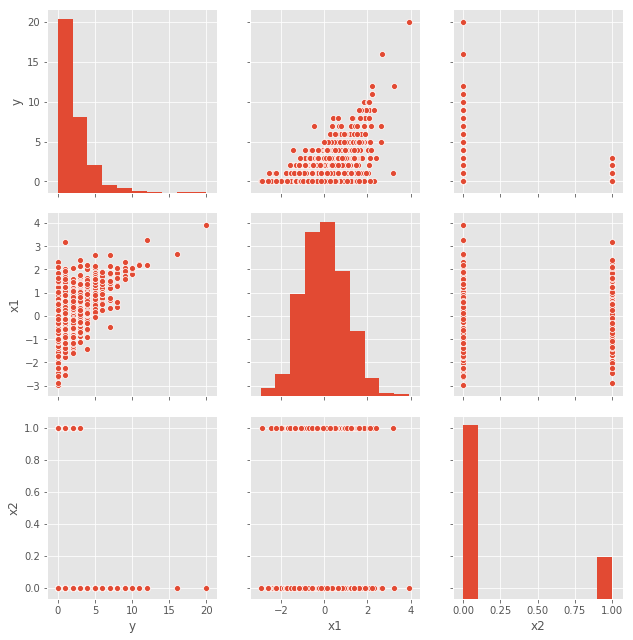

In [10]:
np.random.seed(12345)
N = 1000 # Number of observations

# Linear combination of predictors
x1 = np.random.normal(size=N)            # One continuous predictor 
x2 = np.random.binomial(1,p=.2,size=N)   # One binary predictor 
X = np.column_stack([np.ones(N),x1,x2])  # Compose as a matrix
                     
B = np.array([.5,.7,-2])                 # True Coefficients
mu  = X.dot(B)                           # average rate is a function of x1 and x2

# Convert our linear combination into a "rate" space (i.e. positively defined)
lamb = np.exp(mu) 

# Convert into binary outcome using the Bernoulli distribution
y = np.random.poisson(lam=lamb)

# Visualize
sns.pairplot(pd.DataFrame(dict(y=y,x1=x1,x2=x2)),height=3)
plt.show()

In [11]:
smd.Poisson(y,X).fit().summary()

Optimization terminated successfully.
         Current function value: 1.414652
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                        Poisson   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Wed, 04 Dec 2019   Pseudo R-squ.:                  0.2950
Time:                        07:53:00   Log-Likelihood:                -1414.7
converged:                       True   LL-Null:                       -2006.5
                                        LLR p-value:                9.449e-258
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5047      0.029     17.409      0.000       0.448       0.562
x1             0.6753      0.023     29.288      0.000       0.630       0.721
x2            -1.8784      0.126    -14.852      0.000      -2.126      -1.631
==============================================================================
"""

# Agent Based Models

> "An agent-based model (ABM) is a class of computational models for simulating the actions and interactions of autonomous agents (both individual or collective entities such as organizations or groups) with a view to assessing their effects on the system as a whole. It combines elements of game theory, complex systems, emergence, computational sociology, multi-agent systems, and evolutionary programming. Monte Carlo methods are used to introduce randomness." ([Wiki](https://en.wikipedia.org/wiki/Agent-based_model))

### [Schelling's Model of Segregation](http://nifty.stanford.edu/2014/mccown-schelling-model-segregation/)

A walkthrough regarding how to construct Schelling's model in Python:

- [From Scratch](https://www.binpress.com/simulating-segregation-with-python/)
- [Using Mesa](https://towardsdatascience.com/introduction-to-mesa-agent-based-modeling-in-python-bcb0596e1c9a)